# 21点朴克牌(Blackjack)之策略评估

In [1]:
# 载入相关套件
import numpy as np
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import sys
from collections import defaultdict
import matplotlib

matplotlib.style.use('ggplot') # 设定绘图的风格

In [2]:
# 环境
env = BlackjackEnv()

In [7]:
# 试玩
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print(f"玩家分数: {score} (是否持有A: {usable_ace}), 庄家分数: {dealer_score}")

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # 超过20点，不补牌(stick)，否则都跟庄家要一张牌(hit)
    return 0 if score >= 20 else 1

# 试玩 20 次
for i_episode in range(20):
    observation = env.reset()
    # 开始依策略玩牌，最多 100 步骤，中途分出胜负即结束
    for t in range(100):
        print_observation(observation)
        action = strategy(observation)
        print(f'行动: {["不补牌", "补牌"][action]}')
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print(f"输赢分数: {reward}\n")
            break

玩家分数: 21 (是否持有A: True), 庄家分数: 9
行动: 不补牌
玩家分数: 21 (是否持有A: True), 庄家分数: 9
输赢分数: 0

玩家分数: 15 (是否持有A: False), 庄家分数: 3
行动: 补牌
玩家分数: 17 (是否持有A: False), 庄家分数: 3
行动: 补牌
玩家分数: 22 (是否持有A: False), 庄家分数: 3
输赢分数: -1

玩家分数: 20 (是否持有A: True), 庄家分数: 6
行动: 不补牌
玩家分数: 20 (是否持有A: True), 庄家分数: 6
输赢分数: 1

玩家分数: 20 (是否持有A: False), 庄家分数: 1
行动: 不补牌
玩家分数: 20 (是否持有A: False), 庄家分数: 1
输赢分数: 0

玩家分数: 17 (是否持有A: False), 庄家分数: 7
行动: 补牌
玩家分数: 23 (是否持有A: False), 庄家分数: 7
输赢分数: -1

玩家分数: 17 (是否持有A: False), 庄家分数: 4
行动: 补牌
玩家分数: 27 (是否持有A: False), 庄家分数: 4
输赢分数: -1

玩家分数: 19 (是否持有A: True), 庄家分数: 5
行动: 补牌
玩家分数: 17 (是否持有A: False), 庄家分数: 5
行动: 补牌
玩家分数: 27 (是否持有A: False), 庄家分数: 5
输赢分数: -1

玩家分数: 13 (是否持有A: False), 庄家分数: 4
行动: 补牌
玩家分数: 23 (是否持有A: False), 庄家分数: 4
输赢分数: -1

玩家分数: 16 (是否持有A: False), 庄家分数: 10
行动: 补牌
玩家分数: 26 (是否持有A: False), 庄家分数: 10
输赢分数: -1

玩家分数: 17 (是否持有A: False), 庄家分数: 10
行动: 补牌
玩家分数: 20 (是否持有A: False), 庄家分数: 10
行动: 不补牌
玩家分数: 20 (是否持有A: False), 庄家分数: 10
输赢分数: 1

玩家分数: 18 (是否持有A: False), 庄家分数: 10
行动: 补牌
玩家分数: 28 

In [19]:
# 策略评估函数
def policy_eval(policy, env, num_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)    # 记录每一个状态的报酬
    returns_count = defaultdict(float)  # 记录每一个状态的访问个数
    V = defaultdict(float) # 状态值函数
    
    # 实验 N 回合
    for i_episode in range(1, num_episodes + 1):
        # 每 1000 回合显示除错讯息
        if i_episode % 1000 == 0:
            print(f"\r {i_episode}/{num_episodes}回合.", end="")
            sys.stdout.flush() # 清除画面

        # 回合(episode)资料结构为阵列，每一项目含 state, action, reward
        episode = []
        state = env.reset()
        # 开始依策略玩牌，最多 100 步骤，中途分出胜负即结束
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # 找出走过的所有状态
        states_in_episode = set([tuple(x[0]) for x in episode])
        # 计算每一状态的值函数
        for state in states_in_episode:
            # 找出每一步骤内的首次访问(First Visit)
            first_occurence_idx = next(i for i,x in enumerate(episode) 
                                       if x[0] == state)
            # 算累计报酬(G)
            G = sum([x[2]*(discount_factor**i) for i,x in 
                     enumerate(episode[first_occurence_idx:])])
            # 计算状态值函数
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V    

In [17]:
# 采相同策略
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    # 超过20点，不补牌(stick)，否则都跟庄家要一张牌(hit)
    return 0 if score >= 20 else 1

 10000/10000回合.

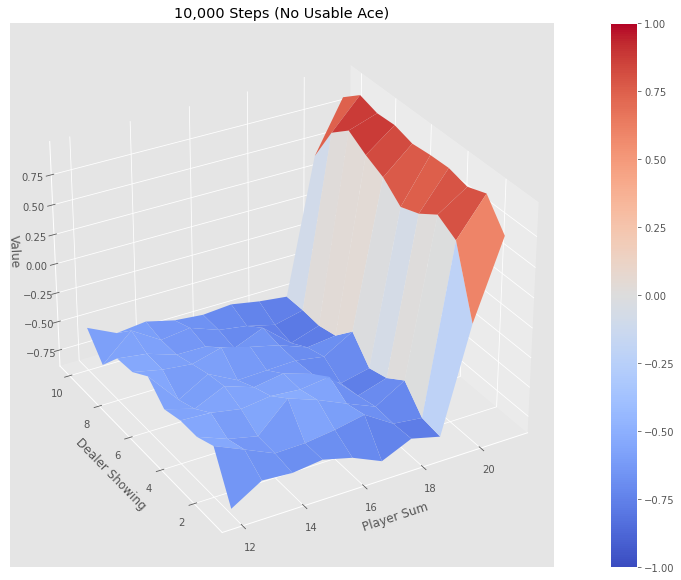

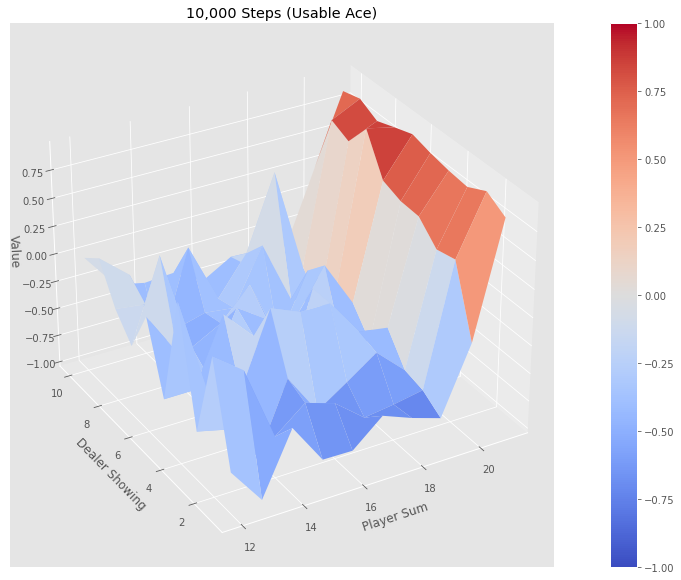

 500000/500000回合.

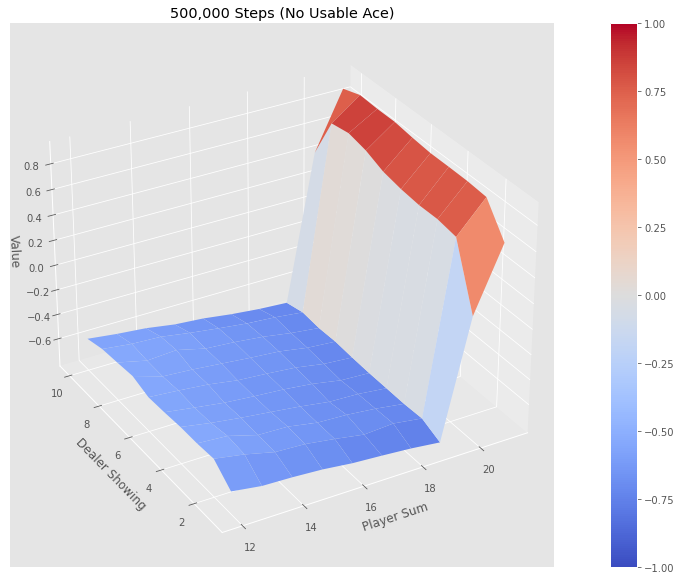

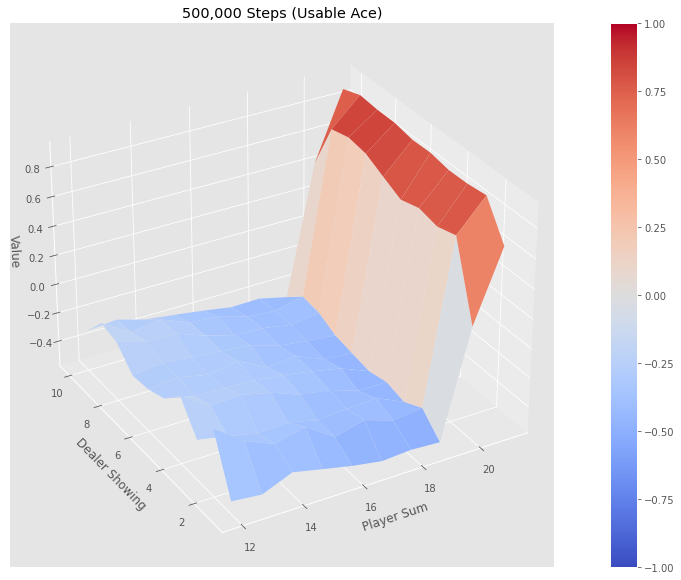

In [18]:
# 实验 10000 回合
V_10k = policy_eval(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

# 实验 500,000 回合
V_500k = policy_eval(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")